In [190]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import GRU
from keras.layers.core import Dropout
from keras.layers.core import flatten
from keras import optimizers





In [191]:
ds = pd.read_csv('/content/drive/MyDrive/train.csv')
ds


,Year,Month,Day,Hour,Minute,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Dew Point,Temperature,Pressure,Relative Humidity,Solar Zenith Angle,Precipitable Water,Wind Direction,Wind Speed,Fill Flag
0,2009,1,1,0,0,0,0,0,0,0.0,5.0,1010,75.34,106.15,0.499,346.1,3.1,0
1,2009,1,1,0,30,0,0,0,0,1.0,5.0,1010,80.81,112.28,0.490,346.1,3.1,0
2,2009,1,1,1,0,0,0,0,4,0.0,5.0,1010,78.27,118.50,0.482,347.9,3.2,0
3,2009,1,1,1,30,0,0,0,4,0.0,4.0,1010,78.27,124.78,0.478,347.9,3.1,0
4,2009,1,1,2,0,0,0,0,4,0.0,4.0,1010,76.45,131.12,0.475,350.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175291,2018,12,31,21,30,51,555,168,4,19.4,20.8,1008,91.77,77.86,3.700,204.0,3.5,100
175292,2018,12,31,22,0,37,388,84,4,19.1,20.1,1008,93.88,83.03,3.800,209.0,3.2,100
175293,2018,12,31,22,30,15,115,18,7,19.1,19.6,1008,96.83,88.32,3.800,208.0,2.6,57
175294,2018,12,31,23,0,0,0,0,7,18.7,19.2,1009,96.84,94.34,3.700,206.0,2.1,0


**the aim of the project is to predict the 'clearsky ghi' values from the data given. its oberved that the data points are recorded in an interval of 30 minutes through the years 2009-2018 on daily basis.**

**convert 	Year	Month	Day hour and minute columns to date column and add it to the dataset**

**drop 	Year	Month	Day hour and minute columns**

In [192]:
ds['date'] = pd.to_datetime(ds[['Year',	'Month','Day', 'Hour', 'Minute']])
a = ds.drop(['Year',	'Month',	'Day', 'Hour', 'Minute' ], axis=1)
#a = a.set_index('date')
#a.head(10)





**statistical observations of the data points. observing the variance of various features**;

**also detecting the correlation among features if any.**

**inspecting null values if any**


In [193]:
#a.describe()

In [194]:
a.info()

a.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175296 entries, 0 to 175295
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Clearsky DHI        175296 non-null  int64         
 1   Clearsky DNI        175296 non-null  int64         
 2   Clearsky GHI        175296 non-null  int64         
 3   Cloud Type          175296 non-null  int64         
 4   Dew Point           175296 non-null  float64       
 5   Temperature         175296 non-null  float64       
 6   Pressure            175296 non-null  int64         
 7   Relative Humidity   175296 non-null  float64       
 8   Solar Zenith Angle  175296 non-null  float64       
 9   Precipitable Water  175296 non-null  float64       
 10  Wind Direction      175296 non-null  float64       
 11  Wind Speed          175296 non-null  float64       
 12  Fill Flag           175296 non-null  int64         
 13  date                175296 no

Index(['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Cloud Type',
       'Dew Point', 'Temperature', 'Pressure', 'Relative Humidity',
       'Solar Zenith Angle', 'Precipitable Water', 'Wind Direction',
       'Wind Speed', 'Fill Flag', 'date'],
      dtype='object')

**CLEARSKY GHI**

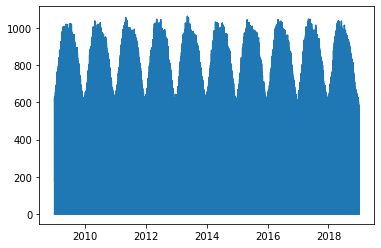

In [195]:
plt.plot(a['date'], a['Clearsky GHI'])

**from the above graph it is apparent that the data is stationary, howerver it is recommended to test the stationarity of the data**

In [196]:
# #perform dickey-fuller test to test the stationarity of the data
# from statsmodels.tsa.stattools import adfuller



In [197]:
# test_result = adfuller(a['Clearsky GHI'])

In [198]:
# #hypothesis

# def adfuller_test(points):
#   result = adfuller(points)
#   labels= ['ADF Test Statistics', 'p-value', 'lags', 'observations']
#   for value, label in zip(result,labels):
#     print(label+':'+str(value))
#   if result[1]<=0.05:
#     print('data is stationary')
#   else:
#     print('data is non-stationary')    

In [199]:
# adfuller_test(a['Clearsky GHI'])

**splitting the data for training and testing purpose. Here splitting is done manually.**


In [200]:
solar_train_set=  a[['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Cloud Type',
       'Dew Point', 'Temperature', 'Pressure', 'Relative Humidity',
       'Solar Zenith Angle', 'Precipitable Water', 'Wind Direction',
       'Wind Speed', 'Fill Flag']].iloc[0:131473]
solar_test_set = a[['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Cloud Type',
       'Dew Point', 'Temperature', 'Pressure', 'Relative Humidity',
       'Solar Zenith Angle', 'Precipitable Water', 'Wind Direction',
       'Wind Speed', 'Fill Flag']].iloc[131473:]     
     


In [201]:
print(solar_train_set.shape)
print(solar_test_set.shape)

(131473, 13)
(43823, 13)


In [202]:
X_train_orig = solar_train_set[['Cloud Type',
       'Dew Point', 'Temperature', 'Pressure', 'Relative Humidity',
       'Solar Zenith Angle', 'Precipitable Water', 'Wind Direction',
       'Wind Speed', 'Fill Flag']].values
y_train =   solar_train_set[['Clearsky GHI']].values   


In [203]:
print(y_train.shape)

(131473, 1)


In [204]:
X_test_orig = solar_test_set[['Cloud Type',
       'Dew Point', 'Temperature', 'Pressure', 'Relative Humidity',
       'Solar Zenith Angle', 'Precipitable Water', 'Wind Direction',
       'Wind Speed', 'Fill Flag']].values
y_test =  solar_test_set[['Clearsky GHI']].values     


**scaling the data using minmaxscaler to scale it in range  from 0 to 1**

In [205]:
ms = MinMaxScaler()
X_train = ms.fit_transform(X_train_orig)
X_test = ms.transform(X_test_orig)


**From the given data, it is observed that there is a difference of 30 minutes among the data points. Hence, a time step of 1 point can be chosen to forecast the data for the next point of time in the sequential order.**



In [206]:
time_steps = 1
def time_series_data(x,y):
  row_dim = time_steps
  col_dim = x.shape[1]
  third_dim = x.shape[0]-time_steps
  print(third_dim,row_dim,col_dim)
  x_time_series_data = np.zeros((third_dim,row_dim,col_dim))
  y_time_series_data = np.zeros(third_dim)
  for i in range(third_dim):
    x_time_series_data[i] = x[i:time_steps+i]
    y_time_series_data[i] = y[time_steps+i]
  return   x_time_series_data, y_time_series_data 



In [207]:
x_train_time_series_data, y_train_time_series_data = time_series_data(X_train,y_train)
x_test_time_series_data,y_test_time_series_data = time_series_data(X_test,y_test)

131472 1 10
43822 1 10


**building  RNN model to predict the output (sequential forecasting)**

In [208]:
batch_size = 100

t_row_dim = time_steps
t_col_dim = X_train.shape[1]
t_third_dim = X_train.shape[0]-time_steps

model = Sequential()
model.add(GRU(3, return_sequences=True, input_shape = (t_row_dim,t_col_dim)))
model.add(GRU(3, return_sequences=False ))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [209]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_12 (GRU)                (None, 1, 3)              135       
                                                                 
 gru_13 (GRU)                (None, 3)                 72        
                                                                 
 dense_6 (Dense)             (None, 1)                 4         
                                                                 
Total params: 211
Trainable params: 211
Non-trainable params: 0
_________________________________________________________________


**below code is for forecasting.**

In [210]:
train_predict = model.predict(x_train_time_series_data)

In [211]:
test_predict = model.predict(x_test_time_series_data)
test_predict

array([[ 0.14146878],
       [ 0.13526388],
       [ 0.15150261],
       ...,
       [-0.01290557],
       [-0.01300118],
       [ 0.23000796]], dtype=float32)

In [212]:
total_predicted = np.vstack([train_predict,test_predict ])
total_predicted

array([[ 0.23060866],
       [ 0.23207931],
       [ 0.26789442],
       ...,
       [-0.01290557],
       [-0.01300118],
       [ 0.23000796]], dtype=float32)

In [213]:
y_predict = np.hstack([y_train_time_series_data,y_test_time_series_data])
y_predict

array([ 0.,  0.,  0., ..., 18.,  0.,  0.])

In [214]:
print(total_predicted.shape)
print(a['date'].shape)

(175294, 1)
(175296,)


**total prediction graph**

Text(0, 0.5, 'total pedicted values')

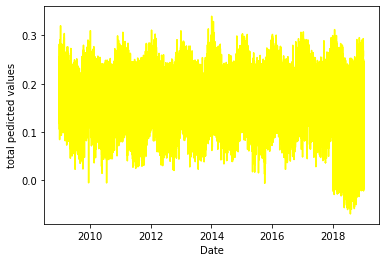

In [215]:
plt.plot(a['date'].iloc[0:175294],total_predicted, color= 'yellow' )
plt.xlabel('Date')
plt.ylabel('total pedicted values')


**based on the below graphs on actual and forecasted values, it is clear that the model built is performing well !**

**ACTUAL GRAPH**

In [216]:
#actual datapoints
d = a[[ 'Cloud Type',
       'Dew Point', 'Temperature', 'Pressure', 'Relative Humidity',
       'Solar Zenith Angle', 'Precipitable Water', 'Wind Direction',
       'Wind Speed', 'Fill Flag']]
d_mms = ms.fit_transform(d)
d_mms


array([[0.        , 0.38724374, 0.28571429, ..., 0.96138889, 0.24031008,
        0.        ],
       [0.        , 0.41002278, 0.28571429, ..., 0.96138889, 0.24031008,
        0.        ],
       [0.4       , 0.38724374, 0.28571429, ..., 0.96638889, 0.24806202,
        0.        ],
       ...,
       [0.7       , 0.82232346, 0.58367347, ..., 0.57777778, 0.20155039,
        0.57      ],
       [0.7       , 0.81321185, 0.5755102 , ..., 0.57222222, 0.1627907 ,
        0.        ],
       [0.7       , 0.81321185, 0.5755102 , ..., 0.57222222, 0.1627907 ,
        0.        ]])

Text(0, 0.5, 'features')

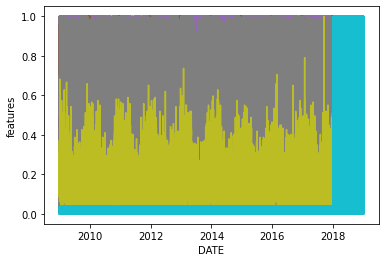

In [217]:
#ACTUAL GRAPH
plt.plot(a['date'], d_mms)
plt.xlabel('DATE')
plt.ylabel('features')



**CLEARSKY GHI PREDICTED GRAPH**

Text(0, 0.5, 'forecast')

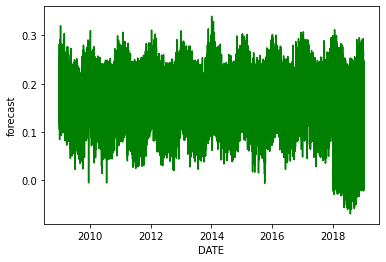

In [218]:
#PREDICTED GRAPH
plt.plot(a['date'].iloc[0:175294], total_predicted, color = 'green')
plt.xlabel('DATE')
plt.ylabel('forecast')

**Clearsky DNI**

In [219]:
X_train_orig_dni = solar_train_set[['Cloud Type',
       'Dew Point', 'Temperature', 'Pressure', 'Relative Humidity',
       'Solar Zenith Angle', 'Precipitable Water', 'Wind Direction',
       'Wind Speed', 'Fill Flag']].values
y_train_dni =   solar_train_set[['Clearsky DNI']].values   


In [220]:
X_test_orig_dni = solar_test_set[['Cloud Type',
       'Dew Point', 'Temperature', 'Pressure', 'Relative Humidity',
       'Solar Zenith Angle', 'Precipitable Water', 'Wind Direction',
       'Wind Speed', 'Fill Flag']].values
y_test_dni =  solar_test_set[['Clearsky DNI']].values     


In [221]:
X_train_dni = ms.fit_transform(X_train_orig_dni)
X_test_dni = ms.transform(X_test_orig_dni)


In [222]:
x_train_time_series_data_dni, y_train_time_series_data_dni = time_series_data(X_train_dni,y_train_dni)
x_test_time_series_data_dni,y_test_time_series_data_dni = time_series_data(X_test_dni,y_test_dni)

131472 1 10
43822 1 10


In [223]:
batch_size = 100

t_row_dim_dni = time_steps
t_col_dim_dni= X_train_dni.shape[1]
t_third_dim_dni = X_train_dni.shape[0]-time_steps

model_2 = Sequential()
model_2.add(GRU(3, return_sequences=True, input_shape = (t_row_dim_dni,t_col_dim_dni)))
model_2.add(GRU(3, return_sequences=False ))
model_2.add(Dense(1))
model_2.compile(optimizer='adam', loss='mean_squared_error')


In [224]:
model_2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_14 (GRU)                (None, 1, 3)              135       
                                                                 
 gru_15 (GRU)                (None, 3)                 72        
                                                                 
 dense_7 (Dense)             (None, 1)                 4         
                                                                 
Total params: 211
Trainable params: 211
Non-trainable params: 0
_________________________________________________________________


In [225]:
train_predict_dni = model_2.predict(x_train_time_series_data_dni)

In [226]:
test_predict_dni = model_2.predict(x_test_time_series_data_dni)
test_predict

array([[ 0.14146878],
       [ 0.13526388],
       [ 0.15150261],
       ...,
       [-0.01290557],
       [-0.01300118],
       [ 0.23000796]], dtype=float32)

In [227]:
total_predicted_dni = np.vstack([train_predict_dni,test_predict_dni ])
total_predicted_dni

array([[ 0.10972681],
       [ 0.11634973],
       [ 0.16510831],
       ...,
       [-0.22551945],
       [-0.19854039],
       [ 0.00202049]], dtype=float32)

In [228]:
print(total_predicted_dni.shape)
print(a['date'].shape)

(175294, 1)
(175296,)


**CLEARSKY DNI TOTAL PREDICTED POINTS**

Text(0, 0.5, 'total pedicted values_dni')

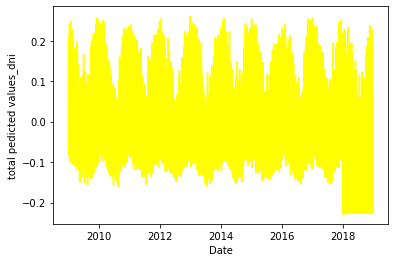

In [229]:
plt.plot(a['date'].iloc[0:175294],total_predicted_dni, color= 'yellow' )
plt.xlabel('Date')
plt.ylabel('total pedicted values_dni')


**CLEARSKY DHI**

In [230]:
X_train_orig_dhi = solar_train_set[['Cloud Type',
       'Dew Point', 'Temperature', 'Pressure', 'Relative Humidity',
       'Solar Zenith Angle', 'Precipitable Water', 'Wind Direction',
       'Wind Speed', 'Fill Flag']].values
y_train_dhi =   solar_train_set[['Clearsky DHI']].values   


In [231]:
X_test_orig_dhi = solar_test_set[['Cloud Type',
       'Dew Point', 'Temperature', 'Pressure', 'Relative Humidity',
       'Solar Zenith Angle', 'Precipitable Water', 'Wind Direction',
       'Wind Speed', 'Fill Flag']].values
y_test_dhi =  solar_test_set[['Clearsky DHI']].values     


In [232]:
X_train_dhi = ms.fit_transform(X_train_orig_dhi)
X_test_dhi = ms.transform(X_test_orig_dhi)


In [233]:
x_train_time_series_data_dhi, y_train_time_series_data_dhi = time_series_data(X_train_dhi,y_train_dhi)
x_test_time_series_data_dhi,y_test_time_series_data_dhi = time_series_data(X_test_dhi,y_test_dhi)

131472 1 10
43822 1 10


In [234]:
batch_size = 100

t_row_dim_dhi = time_steps
t_col_dim_dhi= X_train_dhi.shape[1]
t_third_dim_dhi = X_train_dhi.shape[0]-time_steps

model_3 = Sequential()
model_3.add(GRU(3, return_sequences=True, input_shape = (t_row_dim_dhi,t_col_dim_dhi)))
model_3.add(GRU(3, return_sequences=False ))
model_3.add(Dense(1))
model_3.compile(optimizer='adam', loss='mean_squared_error')


In [235]:
train_predict_dhi = model_3.predict(x_train_time_series_data_dhi)

In [236]:
test_predict_dhi = model_3.predict(x_test_time_series_data_dhi)
test_predict_dhi

array([[-0.00078683],
       [ 0.02842083],
       [ 0.0209194 ],
       ...,
       [ 0.00209513],
       [ 0.00566374],
       [-0.08843793]], dtype=float32)

In [237]:
total_predicted_dhi = np.vstack([train_predict_dhi,test_predict_dhi ])
total_predicted_dhi

array([[ 0.0544898 ],
       [ 0.07431001],
       [-0.02914105],
       ...,
       [ 0.00209513],
       [ 0.00566374],
       [-0.08843793]], dtype=float32)

In [238]:
print(total_predicted_dhi.shape)
print(a['date'].shape)

(175294, 1)
(175296,)


**CLEARSKY DHI TOTAL PREDICTED POINTS**

Text(0, 0.5, 'total pedicted values_dhi')

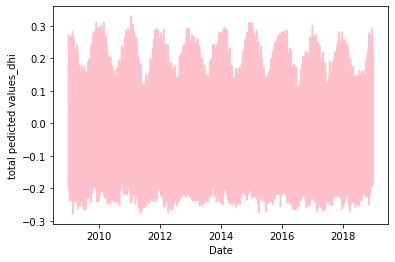

In [239]:
plt.plot(a['date'].iloc[0:175294],total_predicted_dhi, color= 'pink' )
plt.xlabel('Date')
plt.ylabel('total pedicted values_dhi')


**transforming the predicted values into a Dataframe**

In [240]:
clearsky_dhi_predicted_1d =total_predicted_dhi.flatten()
clearsky_dni_predicted_1d = total_predicted_dni.flatten()
clearsky_ghi_predicted_1d = total_predicted.flatten()




In [257]:
dhi_predicted = pd.Series(clearsky_dhi_predicted_1d, name= 'Clearsky DHI')
dni_predicted = pd.Series(clearsky_dni_predicted_1d, name = 'Clearsky DNI')
ghi_predicted = pd.Series(clearsky_ghi_predicted_1d, name = 'Clearsky GHI')


In [266]:
result = pd.concat([dhi_predicted,dni_predicted,ghi_predicted], axis=1)



In [267]:
result_1 = result.iloc[0:17520]


In [268]:
result_1

,Clearsky DHI,Clearsky DNI,Clearsky GHI
0,0.054490,0.109727,0.230609
1,0.074310,0.116350,0.232079
2,-0.029141,0.165108,0.267894
3,-0.016096,0.173303,0.269308
4,-0.007173,0.182553,0.270160
...,...,...,...
17515,0.051136,0.022529,0.150131
17516,0.061160,0.044967,0.152090
17517,0.072114,0.053911,0.156000
17518,0.101206,0.065015,0.152312


In [269]:
result_1.to_csv('forecast_values.csv',index=False)